# Import Required Libraries
Import libraries such as pandas for data manipulation and tabulate for table formatting.

In [21]:
# Import necessary libraries
import pandas as pd  # For data manipulation
from tabulate import tabulate  # For table formatting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Which models have been used 

In [22]:
modeles =["bloom-560m", "bloom-3b", "gpt2-fr", "xglm-2", "bloom-7b", "vigogne-2-7b","croissantbase","croissant-it","llama-3.2-3b-it","llama-3.2-3b","gemma-2-2b","gemma-2-2b-it","mistral-7b-instruct-v0.3", "mistral-7b-v0.3"]

## Recovery of neutral values

In [23]:
dic_df_neutral = {}
for modele in modeles:
    df = pd.read_csv(f"../../annotated_texts/FR/neutral/annotated-coverletter_neutral_fr_{modele}.csv")
    df["modele"]=modele
    dic_df_neutral[modele] = df
    
data_neutre = pd.concat(list(dic_df_neutral.values()), ignore_index=True)
data_neutre = data_neutre[data_neutre["Identified_gender"]!="incomplet/pas de P1"]

data_neutre = data_neutre[~data_neutre["theme"].isin(['electricité, électronique','électricite, électronique', 'études et développement informatique','études géologiques'])]

data_neutre.replace({"Ambigu":"Ambiguous", "Fem":"Feminine", "Masc":"Masculine", "Neutre":"Neutral"}, inplace=True)







In [24]:
data_neutre.shape

(64191, 36)

In [25]:
data_neutre.shape

(64191, 36)

## Recovery of gendered values

In [26]:
dic_df_gendered = {}
for modele in modeles:
    df = pd.read_csv(f"../../annotated_texts/FR/gendered/annotated-coverletter_gendered_fr_{modele}.csv")
    df["modele"]=modele
    dic_df_gendered[modele] = df
    
data_genre = pd.concat(list(dic_df_gendered.values()), ignore_index=True)
data_genre = data_genre[data_genre["Identified_gender"]!="incomplet/pas de P1"]
data_genre.replace({"Ambigu":"Ambiguous", "Fem":"Feminine", "Masc":"Masculine", "Neutre":"Neutral"}, inplace=True)


## Recovery of topics

In [27]:
def trier_dic(dic, reverse_=True):
    L = [[effectif, car] for car, effectif in dic.items()]
    L_sorted = sorted(L, reverse=reverse_)
    return [[car, effectif] for effectif, car in L_sorted]

In [28]:
def exploration_donnees_per_topic(dataset, topic):
    """"Explore data per topic (= professional field).

    Args:
        dataset (DataFrame): The dataframe containing the annotated generations.
        topic (str): The topic (pro. field) to be analyzed.

    Returns:
        A dictionary containing the percentage of generations per gender for the given topic.
    """
    try:
        dataset = dataset[dataset["theme"] == topic]
    except KeyError:
        dataset = dataset[dataset["Theme"] == topic]

    x = dataset["Identified_gender"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
    return x.to_dict()


## GenderGap

In [29]:
def gender_gap_for_model(df):
    """
    Calcule le Gender Gap moyen pour un modèle donné, basé sur les thèmes présents dans le DataFrame.
    Utilise exploration_donnees_per_topic et respecte la logique masc - fem.

    Args:
        df (pd.DataFrame): Données d'un seul modèle

    Returns:
        float: Moyenne des Gender Gaps (par thème)
    """
    try:
        topics = list(set(df["theme"]))
    except KeyError:
        topics = list(set(df["Theme"]))

    gap = {}
    for topic in topics:
        op = exploration_donnees_per_topic(df, topic)

        try:
            m = float(op.get('Masculine', '0%')[:-1])
        except:
            m = 0

        try:
            f = float(op.get('Feminine', '0%')[:-1])
        except:
            f = 0

        gap[topic] = m - f

    if not gap:
        return 0.0

    return(sum(gap.values()) / len(gap))


## GenderShift

In [30]:
def gender_shift(df):
    """"Compute the Gender Shift (= likelihood that the gender given in the prompt is overridden, i.e. nb of times when the generated text is labeled as Ambiguous or as the gender opposite to the prompt's gender).

    Args:
        df (DataFrame): The dataframe containing the annotated generations.

    Returns:
        (int) The resulting Gender Shift
    """
    df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['genre'] == "Neutral") & (
                df['Identified_gender'] != "Neutral") & (df['Identified_gender'] != "incomplet/pas de P1"), 1, 0)

    df = df[df.genre != "Neutral"]
    df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['Identified_gender'] != "Neutral") & (
                df['Identified_gender'] != "incomplet/pas de P1"), 1, 0)

    return sum(df['gender_shift']) / len(df['gender_shift'])


## Fonction to create table

In [38]:
import pandas as pd
from tabulate import tabulate

def generate_great_table_genderGap(data_genre, modeles):
    """
    Génère un tableau stylisé avec tabulate.

    Args:
        data_genre (DataFrame): Le dataframe contenant les données annotées.
        modeles (list): La liste des modèles à inclure dans le tableau.
        type (str): Le type d'expérience ("neutral" ou "gendered").

    Returns:
        DataFrame: Un DataFrame contenant les résultats.
    """
    great_table_columns = [
        "Rank",
        "modele", 
        "GenderGap"        
        ]
        
    rows = []
    for model in modeles:
        df_model = data_genre[data_genre["modele"] == model]
        total = len(df_model)
        if total == 0:
            continue

        gender_gap = gender_gap_for_model(df_model)

        rows.append([
            None,  # Le rang sera calculé plus tard
            model,
            gender_gap
            ])
            

    # Créer le DataFrame
    df = pd.DataFrame(rows, columns=great_table_columns)
    df["DistanceToZero"] = df["GenderGap"].abs()
    # Trier par GenderGap (de la valeur la plus proche de 0 à la plus éloigné) et ajouter les rangs
    df = df.sort_values(by="DistanceToZero", ascending=True).reset_index(drop=True)
    df = df.drop(columns=["DistanceToZero"])
    df["Rank"] = df.index + 1

    # Afficher le tableau avec tabulate
    print(tabulate(df, headers="keys", tablefmt="grid", showindex=False))
    return df

In [45]:
def generate_great_table_gendershift(data, modeles):
    great_table_columns = [
        "Rank",
        "modele", 
        "GenderShift"        
        ]
    
    rows = []

    for model in modeles:
        df_model = data_genre[data_genre["modele"] == model]
        total = len(df_model)
        if total == 0:
            continue

        gender_shift_v = gender_shift(df_model)

        rows.append([
            None,  # Le rang sera calculé plus tard
            model,
            gender_shift_v*100
            ])
    
    # Créer le DataFrame
    df = pd.DataFrame(rows, columns=great_table_columns)
    df["DistanceToZero"] = df["GenderShift"].abs()
    # Trier par GenderGap (de la valeur la plus proche de 0 à la plus éloigné) et ajouter les rangs
    df = df.sort_values(by="DistanceToZero", ascending=True).reset_index(drop=True)
    df = df.drop(columns=["DistanceToZero"])
    df["Rank"] = df.index + 1

    # Afficher le tableau avec tabulate
    print(tabulate(df, headers="keys", tablefmt="grid", showindex=False))
    return df

## Create table with neutral values

In [40]:
neutral_table = generate_great_table_genderGap(data_neutre,modeles)

+--------+--------------------------+-------------+
|   Rank | modele                   |   GenderGap |
+========+==========================+=============+
|      1 | mistral-7b-v0.3          |     0.71133 |
+--------+--------------------------+-------------+
|      2 | xglm-2                   |     1.07586 |
+--------+--------------------------+-------------+
|      3 | croissantbase            |    -8.14532 |
+--------+--------------------------+-------------+
|      4 | bloom-7b                 |    11.0369  |
+--------+--------------------------+-------------+
|      5 | gpt2-fr                  |    12.8138  |
+--------+--------------------------+-------------+
|      6 | bloom-560m               |    15.8192  |
+--------+--------------------------+-------------+
|      7 | bloom-3b                 |    18.9478  |
+--------+--------------------------+-------------+
|      8 | gemma-2-2b               |    23.7034  |
+--------+--------------------------+-------------+
|      9 | c

## Create table with gendered values

In [42]:
gendered_table = generate_great_table_genderGap(data_genre,modeles)

+--------+--------------------------+-------------+
|   Rank | modele                   |   GenderGap |
+========+==========================+=============+
|      1 | mistral-7b-instruct-v0.3 |   -0.347826 |
+--------+--------------------------+-------------+
|      2 | bloom-560m               |    1.14541  |
+--------+--------------------------+-------------+
|      3 | xglm-2                   |    7.05459  |
+--------+--------------------------+-------------+
|      4 | mistral-7b-v0.3          |   -7.72947  |
+--------+--------------------------+-------------+
|      5 | croissantbase            |    9.07053  |
+--------+--------------------------+-------------+
|      6 | gemma-2-2b               |   10.3879   |
+--------+--------------------------+-------------+
|      7 | croissant-it             |   11.4411   |
+--------+--------------------------+-------------+
|      8 | bloom-3b                 |   17.2261   |
+--------+--------------------------+-------------+
|      9 | v

In [46]:
gendered_table_per_shift = generate_great_table_gendershift(data_genre,modeles)

+--------+--------------------------+---------------+
|   Rank | modele                   |   GenderShift |
+========+==========================+===============+
|      1 | xglm-2                   |       32.7939 |
+--------+--------------------------+---------------+
|      2 | mistral-7b-v0.3          |       45.1807 |
+--------+--------------------------+---------------+
|      3 | gemma-2-2b-it            |       46.5941 |
+--------+--------------------------+---------------+
|      4 | gemma-2-2b               |       56.7137 |
+--------+--------------------------+---------------+
|      5 | croissantbase            |       57.7135 |
+--------+--------------------------+---------------+
|      6 | gpt2-fr                  |       60.3462 |
+--------+--------------------------+---------------+
|      7 | vigogne-2-7b             |       64.6898 |
+--------+--------------------------+---------------+
|      8 | bloom-560m               |       65.0865 |
+--------+------------------

/tmp/ipykernel_2683/1197815472.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['genre'] == "Neutral") & (
/tmp/ipykernel_2683/1197815472.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_shift'] = np.where((df['genre'] != df['Identified_gender']) & (df['genre'] == "Neutral") & (
/tmp/ipykernel_2683/1197815472.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [14]:
print("neutral leaderboard\n")
neutral_table

neutral leaderboard



,Rank,modele,GenderGap
0,1,mistral-7b-v0.3,0.711330
1,2,xglm-2,1.075862
2,3,croissantbase,-8.145320
3,4,bloom-7b,11.036946
4,5,gpt2-fr,12.813793
5,6,bloom-560m,15.819212
6,7,bloom-3b,18.947783
7,8,gemma-2-2b,23.703448
8,9,croissant-it,23.893103
9,10,mistral-7b-instruct-v0.3,47.672414


In [15]:
print("gendered leaderboard\n")
gendered_table

gendered leaderboard



,Rank,modele,GenderGap
0,1,mistral-7b-instruct-v0.3,-0.347826
1,2,bloom-560m,1.145411
2,3,xglm-2,7.054589
3,4,mistral-7b-v0.3,-7.729469
4,5,croissantbase,9.070531
5,6,gemma-2-2b,10.387923
6,7,croissant-it,11.441063
7,8,bloom-3b,17.226087
8,9,vigogne-2-7b,18.404348
9,10,bloom-7b,19.932850


In [47]:
print("gendered leaderboard per shift\n")
gendered_table_per_shift

gendered leaderboard per shift



,Rank,modele,GenderShift
0,1,xglm-2,32.793886
1,2,mistral-7b-v0.3,45.180723
2,3,gemma-2-2b-it,46.594124
3,4,gemma-2-2b,56.713673
4,5,croissantbase,57.713466
5,6,gpt2-fr,60.346249
6,7,vigogne-2-7b,64.689781
7,8,bloom-560m,65.086497
8,9,bloom-7b,65.777457
9,10,croissant-it,66.315149


## Recovery of data

In [16]:
modeles=["bloom-560m", "bloom-3b",  "bloom-7b", "gpt2-fr","croissantbase","croissant-it","llama-3.2-3b","llama-3.2-3b-it","gemma-2-2b","gemma-2-2b-it", "mistral-7b-v0.3" ,"mistral-7b-instruct-v0.3", "xglm-2", "vigogne-2-7b"]


In [17]:
def replace_it_with_instruct(d):
    new_dict = {}
    for key, value in d.items():
        new_key = key.replace('it', 'instruct')
        new_dict[new_key] = value
    return new_dict

In [18]:
def create_dic_gendergap(modeles, data_genre):

    dic_gendergap={}
    for model in modeles:
        df_model = data_genre[data_genre["modele"] == model]
        if df_model.empty:
            continue
        gap = gender_gap_for_model(df_model)
        dic_gendergap[model] = gap

    return replace_it_with_instruct(dic_gendergap)

dic_model_ggap=create_dic_gendergap(modeles, data_neutre)
print(dic_model_ggap)


{'bloom-560m': 15.8192118226601, 'bloom-3b': 18.947783251231527, 'bloom-7b': 11.036945812807883, 'gpt2-fr': 12.813793103448274, 'croissantbase': -8.145320197044335, 'croissant-instruct': 23.893103448275863, 'llama-3.2-3b': 65.69852216748768, 'llama-3.2-3b-instruct': 65.57487684729064, 'gemma-2-2b': 23.70344827586207, 'gemma-2-2b-instruct': 57.183251231527095, 'mistral-7b-v0.3': 0.7113300492610838, 'mistral-7b-instruct-v0.3': 47.672413793103445, 'xglm-2': 1.0758620689655172, 'vigogne-2-7b': 69.22955665024631}


In [161]:
def trace_gender_gap(data):
    """
    Trace un graphique en bâtons pour les modèles regroupés par les 4 premiers caractères,
    avec les valeurs arrondies affichées au-dessus des barres.
    
    :param data: Dictionnaire contenant les modèles et leurs GenderGap.
                 Exemple: {"abcd-model1-instruct": 10, "abcd-model2-instruct": 20, ...}
    """
    # Étape 1 : Regrouper les modèles par les 4 premiers caractères
    grouped_data = {}
    for model, gap in data.items():
        group_key = model[:4]  # Les 4 premiers caractères
        if group_key not in grouped_data:
            grouped_data[group_key] = []
        grouped_data[group_key].append((model, gap))

    # Étape 2 : Trier les modèles dans chaque groupe
    for group_key in grouped_data:
        grouped_data[group_key].sort()

    # Étape 3 : Préparer les données pour le graphique
    labels = []
    values = []
    for group_key, models in grouped_data.items():
        for model, gap in models:
            labels.append(model)
            values.append(gap)
        labels.append("")  # Ajouter un espace entre les groupes
        values.append(None)  # Aucun bâton pour l'espace

    x = np.arange(len(labels))  
    plt.figure(figsize=(12, 6))
    bars = plt.bar(x, [v if v is not None else 0 for v in values], color="#1f77b4", edgecolor="black")

    for i, v in enumerate(values):
        if v is None:
            bars[i].set_visible(False)

    for i, bar in enumerate(bars):
        if values[i] is not None:  # Ne pas afficher pour les espaces
            plt.text(
                bar.get_x() + bar.get_width() / 2,  # Position x
                bar.get_height() + (2 if bar.get_height() >= 0 else -5),
                f"{values[i]:.2f}",
                ha="center", va="bottom" if bar.get_height() >= 0 else "top", fontsize=9
            )

    # Ajouter des lignes de référence pour 0, -100 et 100
    plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
    plt.axhline(100, color="red", linewidth=0.5, linestyle="--")
    plt.axhline(-100, color="blue", linewidth=0.5, linestyle="--")

    # Configurer les labels
    plt.xticks(x, labels, rotation=45, ha="right")
    plt.ylabel("GenderGap (%)")
    plt.title("GenderGap per model")

    # Afficher le graphique
    plt.tight_layout()
    plt.show()


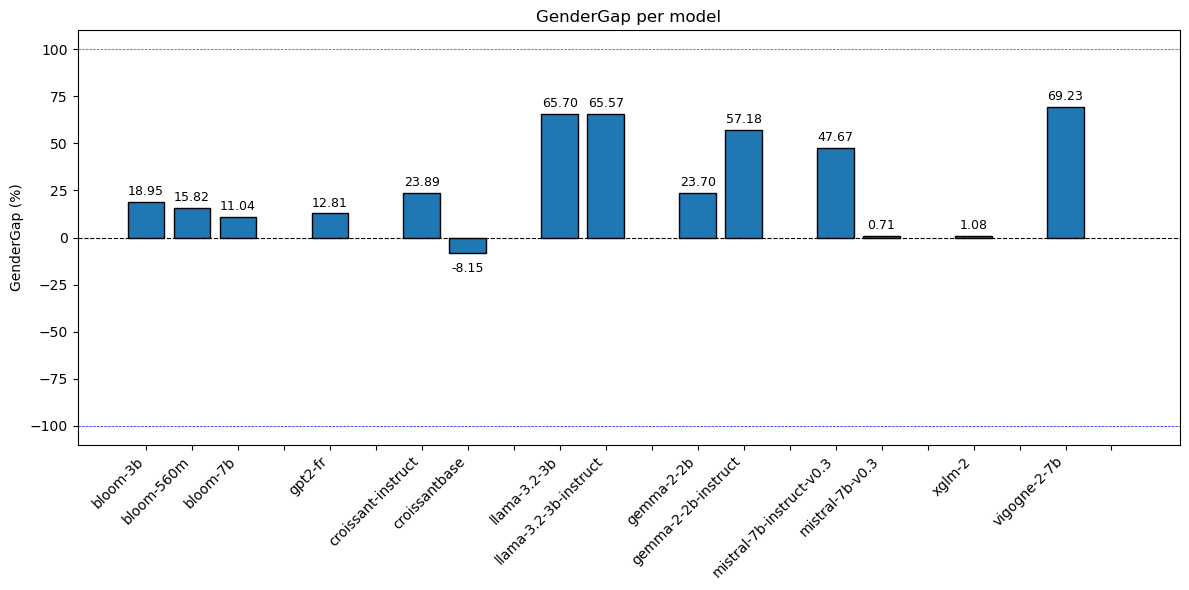

In [162]:
trace_gender_gap(dic_model_ggap)